In [1]:
import pandas as pd
import os 
import numpy as np
import scipy as sp
import scipy.stats as stats
import Bio
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(scImpute)
library(SummarizedExperiment)
###readin1
scdata <- readRDS("scImpute_all_k55/parental_removed.rds")
#####export data for formatting in python, because R sucks majorly
write.table(counts(scdata),file='tmp_counts.csv',sep=',')

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: SummarizedExperiment

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: GenomicRanges

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching pack

In [18]:
%%R

library(M3Drop)
cellLabels <- colData(scdata)$Study_ID

m3dGenes <- M3DropCleanData(
    counts(scdata),
    labels = cellLabels,
    is.counts = TRUE,
    min_detected_genes = 2000
)

### sc methods do not work well for post imputed data, switching to deseq2

                           Gene       p.value       q.value
ENSG00000188976 ENSG00000188976  8.614403e-89  1.146663e-84
ENSG00000187583 ENSG00000187583  1.427442e-08  1.900068e-04
ENSG00000188290 ENSG00000188290 8.440131e-113 1.123466e-108
ENSG00000187608 ENSG00000187608  1.852912e-15  2.466411e-11
ENSG00000188157 ENSG00000188157 1.868821e-145 2.487587e-141
ENSG00000186891 ENSG00000186891  1.018223e-82  1.355356e-78
ENSG00000078808 ENSG00000078808  6.754271e-67  8.990611e-63
ENSG00000176022 ENSG00000176022  1.896908e-99  2.524974e-95
ENSG00000160087 ENSG00000160087 7.734247e-119 1.029506e-114
ENSG00000169972 ENSG00000169972  3.519847e-16  4.685268e-12
ENSG00000127054 ENSG00000127054  1.710920e-63  2.277406e-59
ENSG00000221978 ENSG00000221978 1.404607e-125 1.869672e-121
ENSG00000197785 ENSG00000197785  3.456231e-72  4.600589e-68
ENSG00000160075 ENSG00000160075  2.132955e-13  2.839176e-09
ENSG00000248333 ENSG00000248333  1.023743e-35  1.362705e-31
ENSG00000189339 ENSG00000189339  1.50010

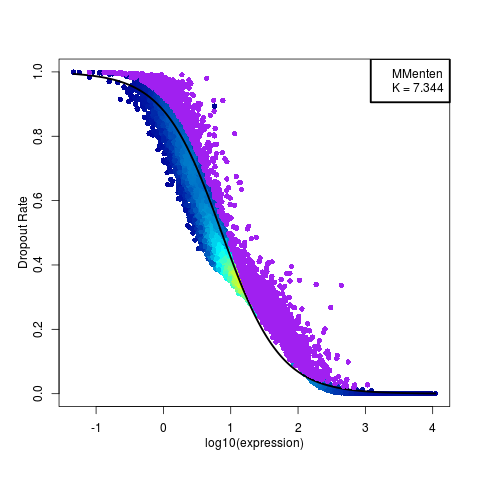

In [29]:
%%R

# Brennecke_HVG <- BrenneckeGetVariableGenes(
#     m3dGenes$data,
#     fdr = 0.01,
#     minBiolDisp = 0.9
# )

# M3DropDifferentialExpression(
#     m3dGenes$data, 
#     mt_method="bon", 
#     mt_threshold=0.01, 
#     suppress.plot=FALSE)

In [47]:
%%R

library(DESeq2)

counts_100rounded <- round(100*counts(scdata))
cellLabels <- DataFrame(factor(colData(scdata)$Study_ID))
colnames(cellLabels) <- c("condition")

dds <- DESeqDataSetFromMatrix(
    counts_100rounded, 
    cellLabels, 
    ~ condition)

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)


In [51]:
%%R

de_results <- DESeq(dds, parallel = TRUE)

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates: 22 workers

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error: 'bplapply' receive data failed:
  error reading from connection

  warnings.warn(x, RRuntimeWarning)



Error: 'bplapply' receive data failed:
  error reading from connection


In [ ]:
d <- counts(scdata)[which(rownames(counts(scdata)) %in% m3dGenes), ]
d <- d[!duplicated(rownames(d)), ]

In [ ]:
%%R

colnames(d) <- 1:ncol(d)
geneNames <- rownames(d)
rownames(d) <- 1:nrow(d)
pd <- data.frame(timepoint = cellLabels)
pd <- new("AnnotatedDataFrame", data=pd)
fd <- data.frame(gene_short_name = geneNames)
fd <- new("AnnotatedDataFrame", data=fd)